## Loading Libraries

In [13]:
#load some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import pickle
import time
import cv2
from tqdm import tqdm
import functools

## Get Data

In [ ]:
#download kaggle data from the drive
! gdown 1TDwN0AGJhTU12e3OYc5kD2sy7dEJuUmO
#create root folder for the project
if not os.path.exists('Steel_Defect_Detection'):
    os.mkdir('Steel_Defect_Detection')
# unzip data to root folder
! unzip 'severstal-steel-defect-detection.zip' -d 'Steel_Defect_Detection/'

In [3]:
#change current directory to root folder
os.chdir('Steel_Defect_Detection')

In [4]:
#we are provided with 2 csv files and 2 folders
os.listdir()

['sample_submission.csv', 'test_images', 'train.csv', 'train_images']

## Problem Statement:

- Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, this competition will help identify defects.
- The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it’s ready to ship. Today, Severstal uses images from high frequency cameras to power a defect detection algorithm.
- In this competition, you’ll help engineers improve the algorithm by localizing and classifying surface defects on a steel sheet.

source: https://www.kaggle.com/c/severstal-steel-defect-detection

## Business Constraints:
- Given that manual inspection of steel defect is a task of high precision we don't want to compromise on that
- Also we don't want defective steel to be classified as not defective
- For classifcation task we want both high precision and high recall (high F1 score)
- Approval of the sample depend on various factors like
    - Application
    - Client
    - Cost
- For example, in some application a particular defect type is not considered as severe for that particular application while in some other application same defect is not at all acceptable
- Therefore it is equally important to identify the defect type as well

## Mapping to Machine Learning:

- Given an input image we want to classify if it contains defect or not
- Also we want to localize the defect and identify the defect type
- We will perform semantic segmentation on input image to localize and identufy the defect type

## Evaluation Metric

- Given that we are now solving semantic segmentation problem it will be good choice to select IOU score or Dice Coefficient as our evaluation metric
-  The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth.
- The formula for dice coefficient is given by:
$  \frac{2 *\left| X \bigcap Y\right|}{\left| X\right|+\left| Y\right|} $

## EDA

In [5]:
#let us first examine train.csv file
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [8]:
#How many images are present with atleast one defect type?
#Total types of defect?
train_images = os.listdir('train_images')
normal_image = list(set(train_images) - set(train_df['ImageId'].unique()))
print("Number of unique class id (defect type): ", train_df['ClassId'].unique().shape[0])
print("Total Train Samples: ", len(train_images))
print("Number of samples id with atleast one defect: ", train_df['ImageId'].unique().shape[0])
print("Number of samples with no defect: ", len(train_images) - train_df['ImageId'].unique().shape[0])

Number of unique class id (defect type):  4
Total Train Samples:  12568
Number of samples id with atleast one defect:  6666
Number of samples with no defect:  5902


In [9]:
def read_image(image, flag='IMREAD_UNCHANGED'):
    #return numpy array
    if flag == 'IMREAD_UNCHANGED':
        return cv2.imread(image, cv2.IMREAD_UNCHANGED)
    elif flag == 'IMREAD_GRAYSCALE':
        return cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    else:
        raise Exception("Please provide valid flag")

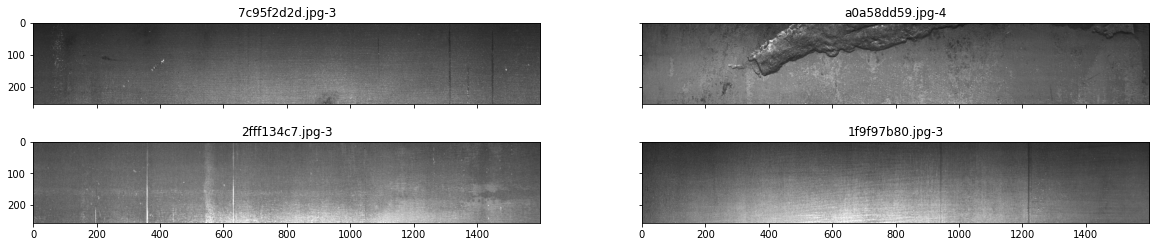

In [10]:
#let us visualize some images with atleast 1 defect
fig, axs = plt.subplots(2,2,figsize=(20,4), sharex=True,sharey=True)
for i in range(4):
    row_id = np.random.randint(0,train_df.shape[0])
    image_id, class_id = train_df['ImageId'].iloc[row_id], train_df['ClassId'].iloc[row_id]
    image_path = os.path.join('train_images', image_id)
    sample_image = read_image(image_path)
    axs[i//2][i%2].imshow(sample_image)
    axs[i//2][i%2].set_title(f'{image_id}-{class_id}')
plt.subplots_adjust()
plt.show()

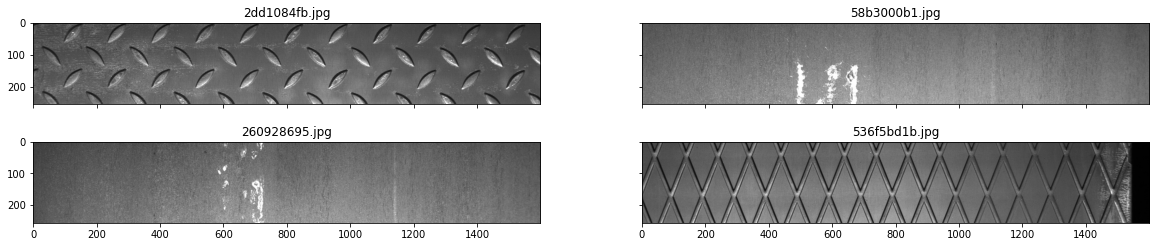

In [11]:
#lastly let us visualize some steel without any defect
fig, axs = plt.subplots(2,2,figsize=(20,4), sharex=True,sharey=True)
for i in range(4):
    row_id = np.random.randint(0,len(normal_image))
    image_id = normal_image[row_id]
    image_path = os.path.join('train_images', image_id)
    sample_image = read_image(image_path)
    axs[i//2][i%2].imshow(sample_image)
    axs[i//2][i%2].set_title(f'{image_id}')
plt.subplots_adjust()
plt.show()

In [14]:
#image width, height distribution
width_list, height_list = [], []
for image_id in tqdm(train_images):
    height, width, _ = read_image(os.path.join('train_images', image_id)).shape
    width_list.append(width)
    height_list.append(height)

for i in range(0, 101, 25):
    print("Image Width {i}th percentile: ", np.percentile(width_list, q=i))
print("="*40)
for i in range(0, 101, 25):
    print("Image Height {i}th percentile: ", np.percentile(height_list, q=i))

100%|██████████| 12568/12568 [01:34<00:00, 132.92it/s]

Image Width {i}th percentile:  1600.0
Image Width {i}th percentile:  1600.0
Image Width {i}th percentile:  1600.0
Image Width {i}th percentile:  1600.0
Image Width {i}th percentile:  1600.0
Image Height {i}th percentile:  256.0
Image Height {i}th percentile:  256.0
Image Height {i}th percentile:  256.0
Image Height {i}th percentile:  256.0
Image Height {i}th percentile:  256.0


## Decoding Encoded Pixels into mask

Encoded Pixels:
- In order to reduce the submission file size, our metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

- The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

source: https://www.kaggle.com/competitions/severstal-steel-defect-detection/overview/evaluation

- According to kaggle input image pixel number format is as below:
    - Starting from top to bottom and then from left to right such that top left pixel in number 1 and bottom right is the last pixel
    -  [1, 4, 7]<br>
       [2, 5, 8]<br>
       [3, 6, 9]
- Encoded Pixel: 1 3 6 5 ---->Implies----> 1 2 3 4 6 7 8 9 10 are encoded pixel position

In [15]:
def transform(encoded_pixel, width=1600, height=256, fill_value=1):
    "return mask of image size (height*width)"
    encoded_pixel_list = list(map(lambda x: int(x), encoded_pixel.split(' ')))
    n = len(encoded_pixel_list)
    encoded_pixel_list = [(encoded_pixel_list[i], encoded_pixel_list[i+1]) for i in range(0, n, 2)]
    #create a flat array of size width*height
    mask = np.zeros(height*width)
    for start, offset in encoded_pixel_list:
        mask[start-1:start+offset-1] = fill_value #minus 1 is because encoded pixel starts from 1 and not 0
    #transpose operation is necessary to match pixel number format
    mask = mask.reshape(width, height)
    return mask.T

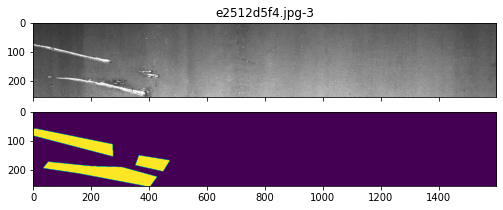

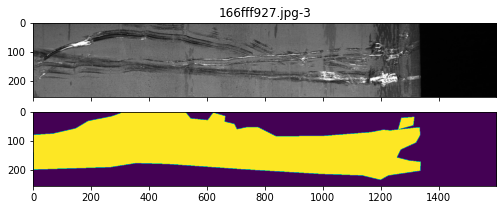

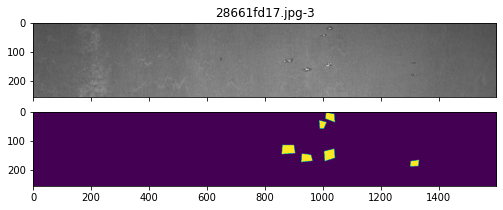

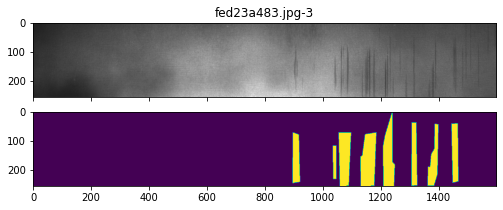

In [16]:
#let us visualize some image along with its mask
for i in range(4):
    row_id = np.random.randint(0,train_df.shape[0])
    image_id, class_id, encoded_pixel = train_df.iloc[row_id, :3]
    #read image file from path
    image = read_image(os.path.join('train_images', image_id))
    height, width, channel = image.shape
    #return mask given encoded pixel
    mask = transform(encoded_pixel, width, height)
    #plot image and corresponding mask
    fig, axs = plt.subplots(2,1,figsize=(11,3),sharex=True)
    axs[0].imshow(image)
    axs[1].imshow(mask)
    axs[0].set_title(f'{image_id}-{class_id}')
    plt.show()

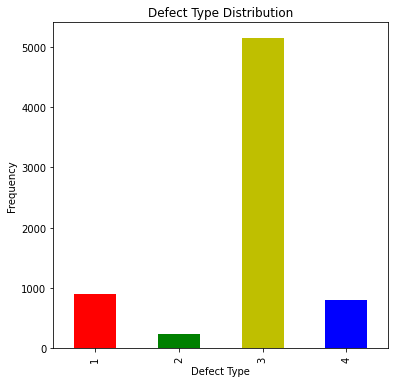

In [17]:
#Which Defect Type is more common?
#Ans: Defect Type 3 is more common followed by 1, 4 and lastly 2
train_df['ClassId'].value_counts().sort_index().plot(kind='bar', figsize=(6,6), color=['r', 'g', 'y', 'b'])
plt.xlabel('Defect Type')
plt.ylabel('Frequency')
plt.title("Defect Type Distribution")
plt.show()

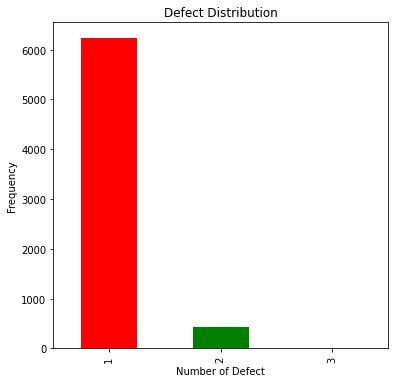

In [18]:
#How common is it to have all 4 defect type in a single sample?
#Ans: It is very unlikely to have all 4 defects in a single sample, mostly we have single defect type per sample
train_df['ImageId'].value_counts().value_counts().sort_index().plot(kind='bar', figsize=(6,6), color=['r', 'g', 'y'])
plt.xlabel('Number of Defect')
plt.ylabel('Frequency')
plt.title("Defect Distribution")
plt.show()

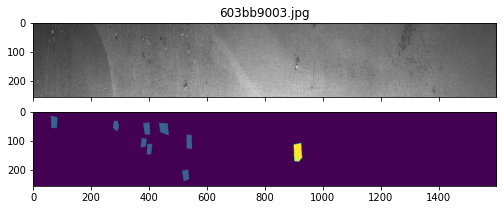

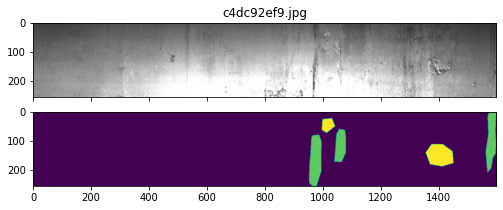

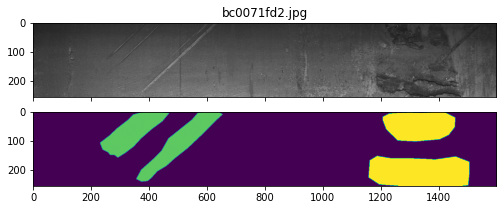

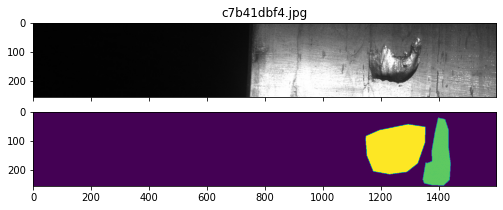

In [94]:
#let us visualize steel with multiple defects

series = train_df['ImageId'].value_counts()
image_id_with_more_than_1_defect = series[(series == 2) | (series == 3)].index

for i in range(4):
    row_id = np.random.randint(0,len(image_id_with_more_than_1_defect))
    image_id = image_id_with_more_than_1_defect[row_id]
    df = train_df[train_df['ImageId']==image_id][['ClassId', 'EncodedPixels']]
    #read image file from path
    image = read_image(os.path.join('train_images', image_id))
    height, width, channel = image.shape
    #return mask given encoded pixel
    if df.shape[0] > 1:
        mask = [transform(df['EncodedPixels'].iloc[j], width, height, df['ClassId'].iloc[j]) for j in range(df.shape[0])]
        mask = functools.reduce(lambda x, y: x+y, mask)
    else:
        mask = transform(df['EncodedPixels'], width, height, df['ClassId'])
    #plot image and corresponding mask
    fig, axs = plt.subplots(2,1,figsize=(11,3),sharex=True)
    axs[0].imshow(image)
    axs[1].imshow(mask)
    axs[0].set_title(f'{image_id}')
    plt.show()

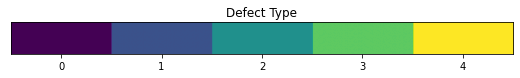

In [80]:
#area covered by different defect types
def calculate_pixel(encoded_pixel):
    encoded_pixel_list = list(map(lambda x: int(x), encoded_pixel.split(' ')))
    n = len(encoded_pixel_list)
    sum = 0
    for i in range(1,n,2):
        sum += encoded_pixel_list[i]
    return sum/(1600*256)
train_df['defective_area'] = train_df['EncodedPixels'].apply(lambda x: calculate_pixel(x))

In [81]:
train_df.head()

,ImageId,ClassId,EncodedPixels,defective_area
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0.010732
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,0.016838
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,0.020310
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,0.169329
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,0.011843


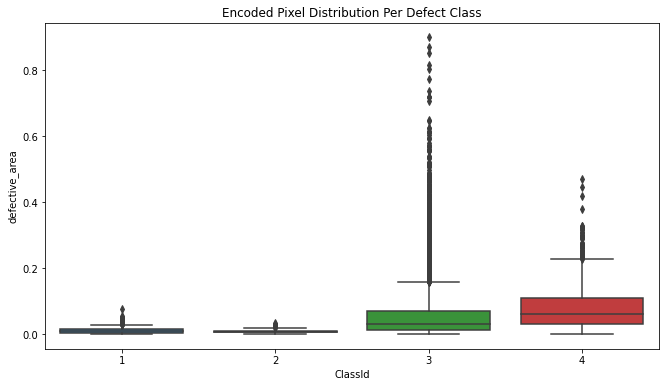

In [82]:
#which defect cover most area in an image?
#Ans: Defect 4 cover maximum pixel followed by defect 3, 1 and last 2
plt.figure(figsize=(11,6))
sns.boxplot(data=train_df, x='ClassId', y='defective_area')
plt.title('Encoded Pixel Distribution Per Defect Class')
plt.show()

Observation:
- More than 50% of defective samples have less than 5% of area entire covered with defect
- It becomes extremely difficult for the model to classify image based on such small portion of defective area

Probable Action / Conclusion:
- Input image is of size: height=256, width=1600
- We will divide input image along its width into 4 equal parts such that single image of size (256 x 1600) will become 4 images of size (256 x 400) each
- This will increase ratio to defective pixel to total pixel in the input image

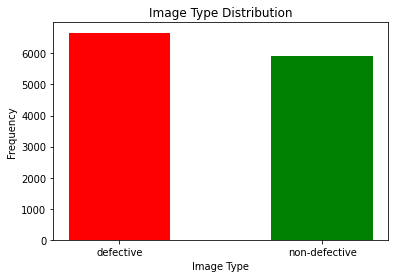

In [ ]:
#What is proportion of defective to normal samples?
#Ans: We have almost equal proportion of defective to normal samples
plt.bar(x=['defective', 'non-defective'], 
        height=[train_df['ImageId'].unique().shape[0], len(train_images)-train_df['ImageId'].unique().shape[0]],
        width=0.5, color=['r', 'g'])
plt.title('Image Type Distribution')
plt.xlabel("Image Type")
plt.ylabel("Frequency")
plt.show()